In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib
matplotlib.style.use('ggplot')

In [2]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

In [3]:
# Set up our tensorflow session.
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Convolutional Neural Networks

Most (all?) machine learning models we have studied so far have been intended to solve very *general* problems.  Convolutional Neural Networks (CNNs) are different, they are designed to address a very specific learning task, **image classification**.

Generalizations of CNNs have been invented to handle other tasks:

  - Audio recognition.
  - Sentiment Analysis in Text.
  - Text Generation (Say, Captioning).  

Many of the main ideas stay mostly the same for these problems, but are adapted to the structure of other types of data.

## Image Classification

**Image Classification** is the task of learning how to label an image.  We are given a set of images to train our model, each with a label identifying its contents:

  - Dog vs. Cat.
  - Name of a digit (0, 1, ..., 9).
  - Name of a flower.
  
The goal of our algorithm is then to learn the *label* of the image from its *contents* (that is, learn the label from the image itself).

### Tensors

We are going to represent images as **tensors**.  Tensors (in machine learning, not mathematics, [tensor](https://en.wikipedia.org/wiki/Tensor) means [something different](http://stats.stackexchange.com/a/198395/74500) in mathematics) are simply multi-dimensional arrays.

  - A one dimensional tensor is a vector.
  - A two dimensional tensor is a matrix.
  - A tensor of larger dimensionality is called a 3-tensor, 4-tensor, etc.
  
So to get an element from a 3-tensor, you need to give it three indices:

```python
three_tensor[i, j, k]
```

And you can slice 3-tensors to get matrices:

```python
# Slicing a 3-tensor by fixing one index gives a 2-tensor, aka a matrix.
three_tensor[i, :, :]
three_tensor[:, j, :]
three_tensor[:, :, k]
```

or vectors:

```python
# Slicing a 3-tensor by fixing one indices gives a 1-tensor, aka a vector.
three_tensor[i, j, :]
three_tensor[:, j, k]
three_tensor[i, :, k]
```

### Grayscale Images

A single greyscale image can be represented as a matrix.  The entries in the matrix represent **pixel intensities**.  A value of 0 represents a white pixel, and a value of zero represents a black pixel.

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


**Note:** Tensorflow has stored this data in *flattened* format, we will unflatten it manually, which is how it would be naturally represented as images.

In [5]:
def plot_greyscale_image(ax, image, label):
    """Plot a greyscale image and label its class."""
    first_digit = image.reshape(28, -1)
    ax.imshow(first_digit, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Class: {}".format(label))

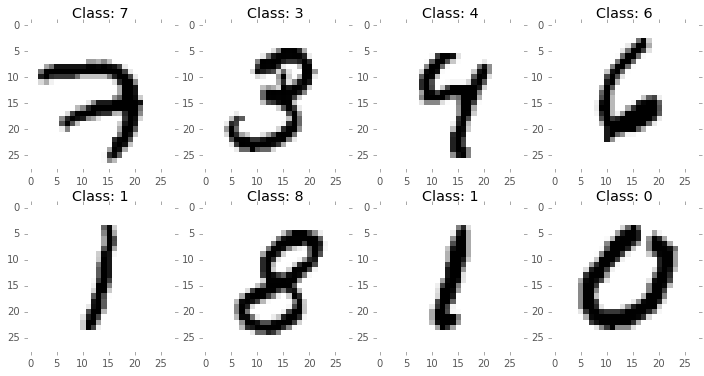

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

digit_labels = np.argmax(mnist.train.labels, axis=1)

for i, (image, label, ax) in enumerate(
    zip(mnist.train.images, digit_labels, axs.flatten())):
    plot_greyscale_image(ax, image, label)
    
remove_grid_lines(axs)

Each image of a digit is represented as a 2-tensor, and is 28 pixels wide and 28 pixels high.

We will often refer to pixel intensities in an image as **activations** n the following way.  Pixels that are "on", or black, are said to be **activated**.  In this way, each digit should be characterized by a characteristic pattern of activations.

In [7]:
digits_training = mnist.train.images.reshape(-1, 28, 28)
first_digit_image = digits_training[0]
print("Shape of digit image: {}".format(first_digit_image.shape))

Shape of digit image: (28, 28)


The entire training data is a stack of 28 by 28 images, which is a 3-tensor.

In [8]:
print("Shape of training data: {}".format(digits_training.shape))

Shape of training data: (55000, 28, 28)


Since `plt.imshow` obscures what is going on a bit, below we can build our own simple plotter by drawing a `.` when the pixel intensity is less than 0.5, and drawing a `#` when it is bigger than 0.5.

In [9]:
def ascii_grayscale_image(img):
    image_shape = img.shape
    ascii = np.array(['#', '.'])[(img >= 0.5).astype(int).flatten()].reshape(image_shape)
    return '\n'.join([''.join(row) for row in ascii])

Now it's easy to see how the matrix represents an image of a digit.

In [10]:
print(ascii_grayscale_image(first_digit_image))

############################
############################
############################
############################
############################
############################
############################
############################
####..............##########
##.................#########
##........#####.....########
#################...########
##################...#######
##################...#######
#################....#######
#############.........######
###########...........######
########........##...#######
#######....#######...#######
######...#########...#######
##################...#######
#################...########
################....########
################...#########
################..##########
###############...##########
############################
############################


### Color Images

Color images are more complex than greyscale.

Instead of a single image being represented as a matrix (greyscale), color images are represented as **three matrices**.  Each of these three matrices is called a **channel**, and holds information on one dimension of the color space.

The standard three channels are RGB, or a **red** channel, a **green** channel, and a **blue** channel.

By stacking these together into a 3-tensor, we can represent a color image as a single object.

--> Picture of a three tensor with channels labeled.

We will use the [Oxford Flowers Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/index.html) as our example of color images.

To download the data set, use the following shell commands:

```bash
curl http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
ype tar -zxvf 17flowers.tgz
```

You will now have a directory containing many color images of flowers.

Set the following variable to the path of the directory you un-tarred your flower images into.

In [11]:
flowers_path = "/Users/matthew.drury/Data/flowers"

Loading this data into Tensorflow is somewhat awkward, but I will include the annotated code here for completeness.

In [12]:
# The number of flower images:
n_flower_images = 1195

# The format specification here left pads zeros on the number: 0004.
flower_filenames = [flowers_path + '/image_{:04d}.jpg'.format(i)
                    for i in xrange(1, n_flower_images + 1)]

# Create a queue of files to read in, a reader object, and 
# then consume the files with the reader.
filename_queue = tf.train.string_input_producer(flower_filenames)
reader = tf.WholeFileReader()

flower_images_list = []
for _ in xrange(1195):
    key, value = reader.read(filename_queue)
    # Each image is a jpg, so we need to decode the raw bytes.
    # channels = 3 creates a 3-tensor with RGB channels.
    flower_image = tf.image.decode_jpeg(value, channels=3)
    flower_images_list.append(flower_image)
    
flower_images = tf.stack(flower_images_list, axis=0)

As is usual with Tensorflow the code *above* only sets up a computation graph, it doesn't actually do and work or computation.

Below, we run the graph.

In [13]:
tf.global_variables_initializer().run()

# Start populating the filename queue.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

coord.request_stop()
coord.join(threads)

Let's check out the first image's shape.

In [14]:
print(flower_images[0].eval().shape)

(583, 500, 3)


The $3$ in the final dimension is the number of color channels.  We see that:

  - This color image is indeed a three tensor.
  - The final dimension is $3$, showing that we do indeed have three color channels.

The proof of the pudding is in the eating of said pudding, so here's the actual image in all it's beauty:

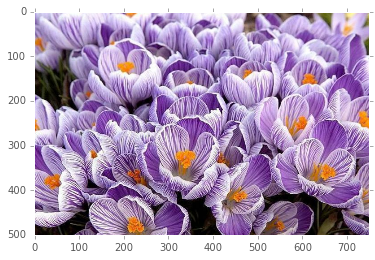

In [15]:
flower_image_np = flower_images[0].eval()
plt.imshow(flower_image_np)
plt.grid(False)

We can also display each of the color channels separately.

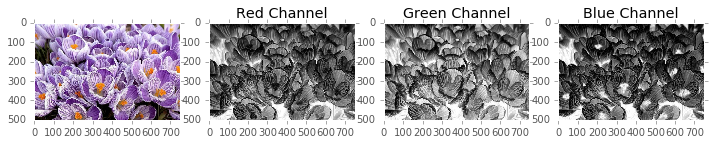

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))

axs[0].imshow(flower_image_np)
axs[0].grid(False)
for i in xrange(1, 4):
    axs[i].imshow(flower_image_np[:, :, i-1], cmap=plt.cm.gray_r)
    axs[i].set_title("{} Channel".format(["Red", "Green", "Blue"][i-1]))

remove_grid_lines(axs)

Since each image is a 3-tensor, the entire dataset is a 4-tensor.

In [17]:
print("Total Data Set Shape: {}".format(flower_images.shape))

Total Data Set Shape: (1195, ?, ?, 3)


**Question:** What's with the `?`'s in the shape of this tensor?

Each image is a **different size**, to do learning on this dataset, you'll have to resize the images to be of a uniform size.  We will cover this in the pair exercise.

## Deficiencies of Fully Connected Networks

In a prior assignment, we used a fully connected neural network to classify digits in the MNIST digit dataset.

Let's review that model, and then discuss some deficiencies of the approach.

### Fully Connected Network Review

In a fully connected network we view each pixel of the input image as a feature.  So instead of viewing an input image as a 2-tensor, we instead **flatten** it into a 1-tensor.

![Flattening a Matrix](./img/image-flatten.png)

To classify an image, we create a unique linear combination of the pixel intensity values for each possible class.  Each pixel participates exactly once in each class's linear combination:

$$ L_j = \underbrace{b_j + W_{1j} x_{1j} + W_{2j} x_{2j} + \cdots + W_{pj} x_{pj}}_{\text{One Summand for Each Pixel}} $$

To assign probabilities to each of the classes, we pass our linear combinations through the **softmax** function.

$$ P_j = softmax(b_j + W_{1j} x_{1j} + W_{2j} x_{2j} + \cdots + W_{pj} x_{pj})_j $$

It is common to visualize this as a network diagram with:
    - One input layer, representing the pixel intensities in an image.
    - One pre-output layer, representing the linear combination of pixel intensities.
    - One output layer, containing probabilities.

![Fully Connected Network with No Hidden Lectures](./img/nn-fc-small.png)

It's easy to train this model in Tensorflow, so let's do so and see how it performs.

In [18]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])

# Weights.  There are 10 output classes, and one weight per (pixel, output class)
# combination.
W = tf.Variable(tf.zeros([28*28, 10]))

# Biasies.  This is like an intercept term in a linear regression.  There is one
# per output class.
b = tf.Variable(tf.zeros([10]))

# Output layer, probabilities of each class.
y_hat = tf.nn.softmax(tf.matmul(x, W) + b)

# Our loss function.
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

In [19]:
# Train the model by gradient descent, for a fixed 1000 iterations.
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

tf.global_variables_initializer().run()
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})

In [20]:
# Evaluate the classification accuracy.  What percentage of the test digits were
# correctly classified.
prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Test Error Accuracy: {:0.2f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})))

Test Error Accuracy: 0.92


The fully connected network classifies $92\%$ of the digits correctly.  We will be able to improve on this with a convolutional network. 

### Flattening

The most glaring deficiency of the fully connected network is its *flattening of the images*.

Images have structure that is destroyed when flattening them.  Pixels that **were** close together become far apart after flattening.

![Image Flattening With Shaded Pixels](./img/img-flatten-non-local.png)

We should expect the neighbouring pixels in an image to combine in ways that convey information.  Flattening the image makes it extremely difficult for the network to detect information conveyed by close together pixels.

We can see this by plotting the fit weights in the fully connected network.

In [21]:
def plot_digit_weights(ax, digit):
    """Plot the weights from our fit fully connected network as an image."""
    digit_weigths = W.eval()[:, digit].reshape(28, -1)
    ax.imshow(digit_weigths, cmap=plt.cm.winter, interpolation="nearest")

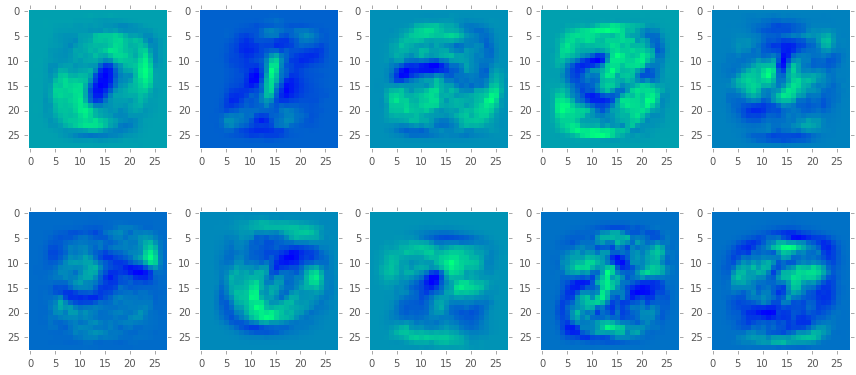

In [22]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for digit, ax in enumerate(axs.flatten()):
    plot_digit_weights(ax, digit)

remove_grid_lines(axs)
plt.tight_layout()

The weights for simple digits (one, zero) show considerable structure.

The weights for more complex digits (four, five, nine) are a bit of a mess.  The network clearly had some issues structuring the weights into comprehensible signal.

### Absolute Positioning

Looking at the weights above again, we can see that the fully connected network is only sensitive to the shape of the digits if they are **in the same general position of the image every time**.

If, for example, we had an image of a $6$, but written in the upper right hand corner of our image, we would totally fail to detect it.  Even retraining the network on a new batch of images that have been shifted or rotated around would not help, as we are assigning weights to each (digit, pixel) combination.

A CNN will learn features that can be applied anywhere in the image, which will fix this issue.

### Number of Parameters

Our fully connected network fits a huge number of parameters.  There are:
  - `n_digits` bias parameters.
  - `n_digits * n_pixels` weight parameters.
  
Overall the network we fit has:

$$ 10 + (10 * 28 * 28) = 7850 $$

parameters.  We will be able to reduce this number with a convolutional approach.

## Image Transformations: Convolutions and Pooling

The major conceptual building block of CNNs are **convolutions**.  These are linear operations that transform an image into another image.

### Gaussian Filter

The earliest application of convolutions in images is **denoising** using a **Gaussian filter**.

Consider the following 2-tensor, called a **filter**.

In [23]:
gaussian_filter = (1/256.0) * np.array([
    [1, 4,  6,  4,  1], 
    [4, 16, 24, 16, 4], 
    [6, 24, 36, 24, 6], 
    [4, 16, 24, 16, 4], 
    [1, 4,  6,  4,  1]
]).astype(np.float32)

We will display these filters as greyscale images, which will make it easier to see their structure, especially as they get more complicated.

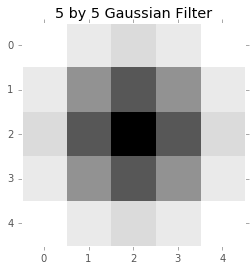

In [24]:
plt.imshow(gaussian_filter, cmap=plt.cm.gray_r, interpolation="nearest")
plt.title("5 by 5 Gaussian Filter")
plt.grid(False)

The numbers in a filter are called it's **weights** or **activations**.  So in the Gaussian filter the biggest weight is in the center, and the values of the weights decrease as we move away from the center.

Tensorflow includes a function `nn.conv2d` which **applies** this convolution to an image (or more generally, a tensor).  Let's see what this operation does to a familiar image.

In [25]:
def apply_convolution_to_image(image, convolutional_filter, 
                               image_shape=(28, 28),
                               filter_shape = (5, 5)):
    """Apply a convolutional filter to an image.  The inputs here should be
    numpy arrays, this function will take care of converting them to tensors
    and back.
    """
    # The image and filter tensor must be 4-tensors to use conv2d.  This
    # will eventually make sense, as we build up the complexity of our
    # filters.
    image_tensor = tf.constant(image.reshape(1, image_shape[0], image_shape[1], 1))
    filter_tensor = tf.constant(
        convolutional_filter.reshape(filter_shape[0], filter_shape[1], 1, 1))
    convolved_tensor = tf.nn.conv2d(
        image_tensor, filter_tensor, 
        strides=[1, 1, 1, 1], padding='SAME')
    image_convloved = convolved_tensor.eval()[0, :, :, 0]
    return image_convloved

We will eventually explain the meaning of the reshapes in the function, but in short, Tensorflow always expects to be working on a 4-tensor.  A single image can be represented as a 4-tensor with shape:

```python
(1, image_height, image_width, 1)
```

In [26]:
first_digit_blurred = apply_convolution_to_image(first_digit_image, gaussian_filter)

In [27]:
def plot_convolution(before, convolutional_filter, after, axs):
    """Plot a 1 by 3 grid of images:
        - A before image.
        - A filter to apply.
        - The result of convolving the filter with the image.
    """
    axs[0].imshow(before, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Before Convolution")
    axs[1].imshow(convolutional_filter, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Filter")
    axs[2].imshow(after, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[2].set_title("After Convolution")

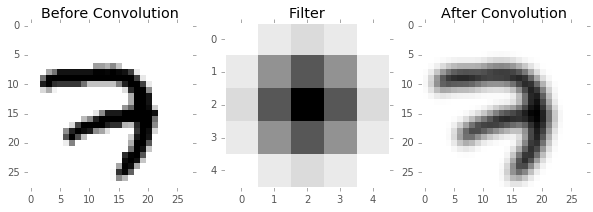

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

plot_convolution(first_digit_image, gaussian_filter, first_digit_blurred, axs)
remove_grid_lines(axs)

**Discussion:** Given the before and after image, and the shape of the filter we applied, what does the operation of **convolution** do?

### Applying a Convolution to an Image

Remember, a convolution is an operation that *combines an image and a filter to create a new image*.

Lets say we have a *28 by 28* image, and a *3 by 3* filter.  The result of the convolution operation is *another 28 by 28* image.

![A Schematic Of A Convolutional Filter](./img/convolution.png)

As hinted at by the picture, the first step is to *overlay the filter on each 3 by 3 patch of the image*.  By sliding the filter around, we eventually cover each 3 by 3 patch of the image. 

At the edges, the filter will spill out over the boundaries of the image, so we just pretend the values of the pixels are zero outside the image border.

![Example of Filter as a Dot Product](./img/convolution-example.png)

The final pixel value in the output image is a dot product of the pixel intensities underneath the patch, with the weights in the filter directly above the pixel. 

The name of this operation is a **convolution**, so we can say we **convolve the filter with the image to create our output image**.

**Discussion:** Given this understanding, why does convolution with a Gaussian filter result in a *fuzzed out* version of the image?

### Edge Detectors

Another type of interesting filter, which will be most important in understanding how CNNs work, is an **edge detector**.

In [29]:
vertical_edge_filter = np.array([
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1]
]).astype(np.float32)

horisontal_edge_filter = np.array([
    [1,   1,   1,   1,   1],
    [1,   1,   1,   1,   1],
    [0,   0,   0,   0,   0],
    [-1, -1,  -1,  -1,  -1],
    [-1, -1,  -1,  -1,  -1]
]).astype(np.float32)

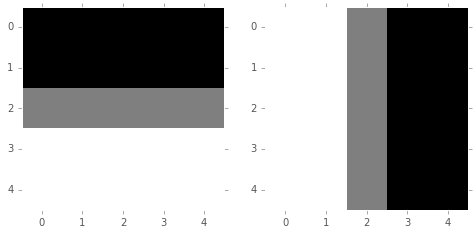

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].imshow(horisontal_edge_filter, cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow(vertical_edge_filter, cmap=plt.cm.gray_r, interpolation="nearest")

remove_grid_lines(axs)

Edge detectors show a linear pattern in their weights, they tend to be constant in a fixed direction, and vary from positive to negative along an orthogonal direction.

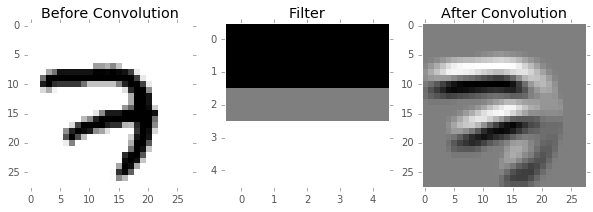

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_h_edges = apply_convolution_to_image(first_digit_image, horisontal_edge_filter)
plot_convolution(first_digit_image, horisontal_edge_filter, first_digit_h_edges, axs)

remove_grid_lines(axs)

**Discussion:** What did the edge detector do, what feature of the image did it highlight?  (Remember, black pixels are the **activations**, you should think about what the back pixels in the convolved image are detecting).

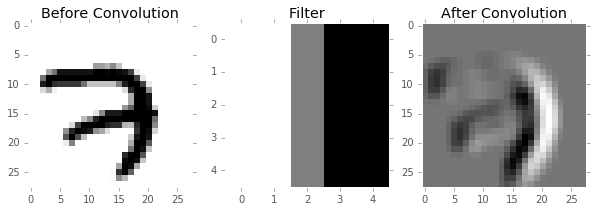

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_v_edges = apply_convolution_to_image(first_digit_image, vertical_edge_filter)
plot_convolution(first_digit_image, vertical_edge_filter, first_digit_v_edges, axs)

remove_grid_lines(axs)

**Exercise:** Design an edge detector to highlight the *diagonal* edges in the image.  Apply it to the image to see it in action!

In [33]:
diagonal_edge_filter = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]).astype(np.float32)

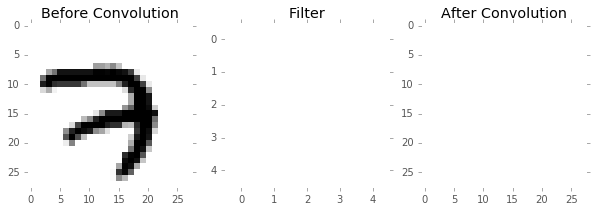

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_d_edges = apply_convolution_to_image(first_digit_image, diagonal_edge_filter)
plot_convolution(first_digit_image, diagonal_edge_filter, first_digit_d_edges, axs)

remove_grid_lines(axs)

### Max Pooling

A more simple transformation of an image into another is **max pooling**.

In max pooling we again overlay smaller squares onto our image, but this time we tile the squares with no overlap.

The final pixel value in the output image is simply the maximum pixel value over all pixels contained in a region defined by one of the small squares.

![Schematic of Max Pooling](./img/pool.png)

In [35]:
def apply_max_pool_to_image(image, image_shape=(28, 28), filter_shape = (2, 2)):
    image_tensor = tf.constant(image.reshape(1, image_shape[0], image_shape[1], 1))
    image_pooled_tensor = tf.nn.max_pool(
        image_tensor, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    image_pooled = image_pooled_tensor.eval()[0, :, :, 0]
    return image_pooled

In [36]:
def plot_max_pool(image, pooled_image, axs):
    axs[0].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Raw Image")
    axs[1].imshow(pooled_image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Pooled Image")

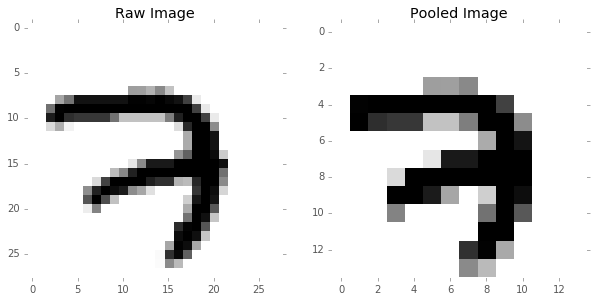

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

first_digit_pooled = apply_max_pool_to_image(first_digit_image)
plot_max_pool(first_digit_image, first_digit_pooled, axs)

remove_grid_lines(axs)

You can see that max pooling has **downsampled** the image.  We have a smaller image, but displaying the same content at a lower resolution.

Convolutions and max pooling have fundamentally different uses and intent:
  - Convolutions can be used to highlight or manipulate the some structure in an image.
  - Max pooling simply downsamples an image to another of smaller size.

### Rectified Linear Unit

Notice that when we convolve an edge detector with an image, the non-edge parts of the image devolve into a grey sludge:

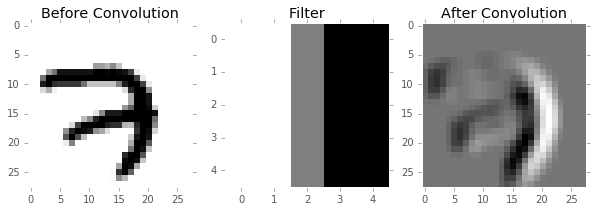

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

plot_convolution(first_digit_image, vertical_edge_filter, first_digit_v_edges, axs)

remove_grid_lines(axs)

If we are mostly concerned with where there are and are not edges, we are only really concerned with parts of the transformed image where the activations are large and positive.  I.e., the white parts of the convolved image.

A **Rectified Linear Unit** serves to highlight these parts of the image.  It simply implements the following *fixed* transformation:

$$ f(x) = \max(x, 0) $$

In [39]:
def apply_relu(image):
    """Apply a rectified linear unit to an image."""
    return (image * (image >= 0))

In [40]:
def plot_relu(image, rectified_image, axs):
    axs[0].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Initial Image")
    axs[1].imshow(rectified_image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Rectified Image")

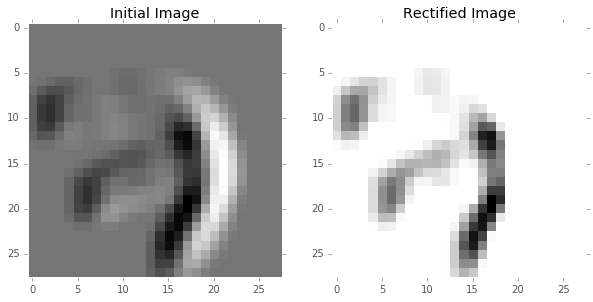

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

first_digit_v_edges_relu = apply_relu(first_digit_v_edges)

plot_relu(first_digit_v_edges, first_digit_v_edges_relu, axs)
remove_grid_lines(axs)

Now the final image only highlights the regions in the original image where an edge was detected.

#### Chaining Transformations

In CNNs, these three types of transformations are commonly chained together in the sequence:

```
Convolution -> Rectified Linear Unit -> Max Pool
```

Which we can think of as follows:
  - The convolution identifies which regions of an image have a feature.
  - The rectified linear unit highlights only the region where the feature exists.
  - The max pooling downsamples their resulting information to save space and computation.

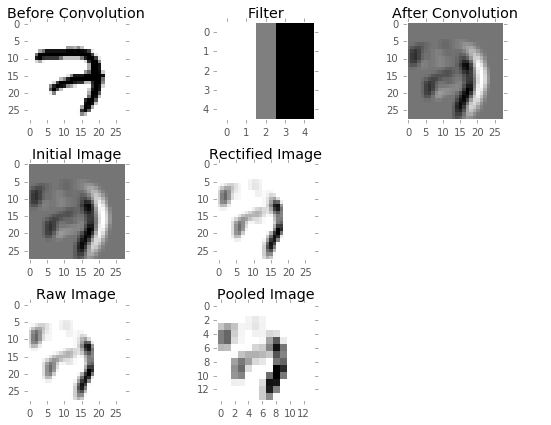

In [42]:
fig, axs = plt.subplots(3, 3, figsize=(8, 6))

plot_convolution(first_digit_image, vertical_edge_filter, first_digit_v_edges, axs[0, :])
plot_relu(first_digit_v_edges, first_digit_v_edges_relu, axs[1, :])
plot_max_pool(first_digit_v_edges_relu,
              apply_max_pool_to_image(first_digit_v_edges_relu),
              axs[2, :])

axs[1, 2].axis('off')
axs[2, 2].axis('off')
remove_grid_lines(axs)
plt.tight_layout()

**Discussion:** How would you detect a *dot* in an image, for example, the dot on the top of a lower case `i`?

**Discussion:** Why use the maximum operation to down sample an image, instead of an average or other operation.

## Convolutional Neural Network Architecture

A convolutional neural network works, as the name hints, by dissecting an image through applying various convolutions.

During training, the job of the network is to discover, from the data, appropriate convolutions that highlight features of the images which help to distinguish between the various classes we are attempting to learn.

The architecture is *layered*, as in the image below:

![Schematic of a Complete CNN Beginning](./img/deep-network-begin.png)
![Schematic of a Complete CNN End](./img/deep-network-end.png) 

There are two layers in the CNN above (though what exactly constitutes a layer seems to vary across sources).  Each layer implements the chained transformation we discussed above:
    
```
Convolution -> Rectified Linear Unit -> Max Pool
```

In our network, we've chained together two layers, followed by a fully connected layer, which connects to an output layer, in the same way as in fully connected networks:

```
INPUT -> (CONV -> RELU -> POOL) -> (CONV -> RELU -> POOL) -> FULL-CONN -> OUTPUT
```

Below, we will discuss the details of these two layers.  We will assume that our network is **already trained**, so we will be describing a **forward pass**, i.e. what happens to an image that is fed into the network.

### The First Layer

The first layer of our CNN acts on the initial image:
    
```
INPUT -> (CONV -> RELU -> POOL) -> ...
```

We already understand what this does when `CONV` is a *single* convolutional filter, this is what we discussed extensively in the previous session.

In a CNN though, the `CONV` unit applies **multiple** convolutional filters to the image.

![First Layer Convolutional Filter](./img/convolution-first-layer.png)

Suppose our input image is 28 by 28.  Since there is one image, and we have one color channel (greyscale) we can consider this a 4-tensor of dimensions `(1, 28, 28, 1)`, where:

  - The first `1` is the *one image*.
  - The last `1` is the *one channel*.
  
Suppose that we have sixteen convolutional filters in our first layer.  Each filter is applied to the image independently, so the result is **sixteen 28 by 28 images**.

Here we re-use some terminology, the eight output images are again called **channels**, so the output of the first convolutional layer is a tensor with sixteen channels.

So, in all, our dimensions transform as:

```
(1, 28, 28, 1) --SIXTEEN CONVOLUTIONS--> (1, 28, 28, 16)
```

**Convention:** Whenever we have a tensor holding *data*, i.e. an image, multiple images, or transformed images, we will use the following convention for our dimensions:

```
(n_input_images, image_height, image_width, n_channels)
```

After the convolutions, the `RELU` and `POOL` simply act over each channel independently.  So the dimensions work out as:

```
(1, 28, 28, 1) --CONV--> (1, 28, 28, 16)
               --RELU--> (1, 28, 28, 16)
               --POOL--> (1, 14, 14, 16)
```

#### Tensorflow Code

Lets set up the Tensorflow code for our first layer.

For training, we will need to initialize all the weights in our filters to random positive values (initializing to zero can cause convergence issues).

In [43]:
# Tensors representing our input dataset and our input labels
x = tf.placeholder(tf.float32, shape=[None, 28*28])
y = tf.placeholder(tf.float32, shape=[None, 10])

# When passing through the network, we want to represent the images
# as a 4-tensor: (n_images, image_height, image_width, n_channels)
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [44]:
# Weights are a 4-tensor of shape:
# (filter_height, filter_width, input_channels, output_channels)
# So here we set up 16 (5 by 5) filters in our first layer.
weights1 = tf.Variable(
    tf.truncated_normal(shape=[5, 5, 1, 16], stddev=0.1))

# One bias for each convolutional filter.
bias1 = tf.Variable(tf.constant(0.1, shape=[16]))

# The result tensor of convolving the input data with the first layer
# of filters.
# strides controls how to slide the filter around the image.
# padding='SAME' guarantees the output image is the same shape as the input.
conv1 = tf.nn.conv2d(x_image, weights1,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

# Pass the convolved result through a RELU.
relu1 = tf.nn.relu(conv1 + bias1)

# Pool.
# ksize is the size of the windows to overlay.
# strides controls how to slide the windows around the image.
layer_1_out = tf.nn.max_pool(relu1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')               

The code above should be understandable, except for possibly our construction of the weights variable for the convolutional filters:

```
weights1 = tf.Variable(
    tf.truncated_normal(shape=[5, 5, 1, 16], stddev=0.1))
```

The shape here, as indicated in the comments, is interpreted as:

```
(filter_height, filter_width, input_channels, output_channels)
```

Which creates a total number of

```
filter_height * filter_width * input_channels * output_channels
```

weights to be trained.

**Convention:** Whenever we have a tensor representing a **collection of convolutional filters**, we will use the following convention for our dimensions: `(filter_height, filter_width, input_channels, output_channels)`.

In our case, there is only one input channel, as our input images are greyscale.  In the subsequent layer, we will have multiple input channels, one for each output channel of the convolutions in this layer.

#### Structure of the First Layer Convolutional Filters

The first layer of convolutions in a well constructed CNN frequently show the same type of structures.  The tend to be **edge and point detectors**.

Here is a picture of the fit convolutional filters from a well trained CNN with many layers.

![Edge and Blob Detectors](./img/mnist-deep-net-first-layer.jpeg)

Source: http://cs231n.github.io/convolutional-networks

These filters have very clearly converged to edge and color blob detectors.  This is pretty cool.

### The Second Layer

The second layer of our CNN acts on (takes as input) the output of our previous layer:
    
```
LAYER_1_OUTPUT -> (CONV -> RELU -> POOL) -> ...
```

This means that the *input* data tensor is a 4-tensor with shape `(1, 14, 14, 16)`.  Recall from above, this tensor represents a *stack of 16 images*.

**Question:** How should we generalize our concept of **convolution** to process a *stack* of images?

**Our prior concept** of a convolution processed a single image (2-tensor) using a filter, which was also a 2-tensor.  Each of our filters in our convolutional unit had a shape:

```
(filter_height, filter_width)
```

and was combined with an image of shape:

```
(image_height, image_width)
```

![A Schematic Of A Convolutional Filter](./img/convolution.png)

**Now** we need to process a 3-tensor (stack of images), so our filter will *also* need to be a 3-tensor.  We will generalize the above to have filters of shape:

```
(filter_height, filter_width, filter_depth)
```

Which we will combine with an image of shape:

```
(image_height, image_width, n_channels)
```

This combination is a direct generalization of the previous case, we only overlay **volumes** instead of **areas**.

![Three Dimensional Filter](img/three-dim-filter.png)

We always make one simplifying restriction in the context of CNNs:

> We will always use filters whose depth is **equal** to the numbers of channels in the image.

Altogether, our second (and subsequent) convolutional layers will have a 4-tensor of weights, of shape:

```
(filter_height, filter_width, input_channels, output_channels)
```

This means there are

```
filter_height * filter_width * input_channels * output_channels
```

total convolutional weights in this layer.

This layer transforms an input tensor of shape

```
(n_input_images, image_height, image_width, n_channels)
```

into an output tensor of shape

```
(n_input_images, image_height, image_width, new_n_channels)
```

**Note:**  These convolutional layers are impossible to draw an accurate picture of, as we cannot draw four dimensional volumes.  I'll continue to draw them as three dimensional parallelepipeds, but you should keep in mind that the truth is slightly more complicated.

#### Example: Identifying a Higher Level Feature

To see what a later convolutional layer is trying to do, let's consider a simple example.

In [45]:
# Load a image of a zero.  Necessary because we always get the mnist
# dataset in a random order.
clean_zero = np.load("zero.npy")

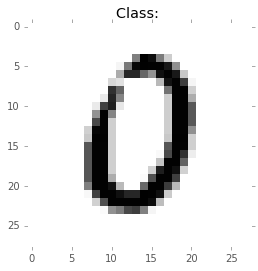

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_greyscale_image(ax, clean_zero, "")
ax.grid(False)

Let's see how we can combine *two* convolutional layers to detect the upper left hand arc of the zero in this picture.

It's not possible to detect this feature with the simple linear edge detectors we have discussed up until now, but we *can* combine them to get the job done.

Let's start by applying our three edge detectors to this image.

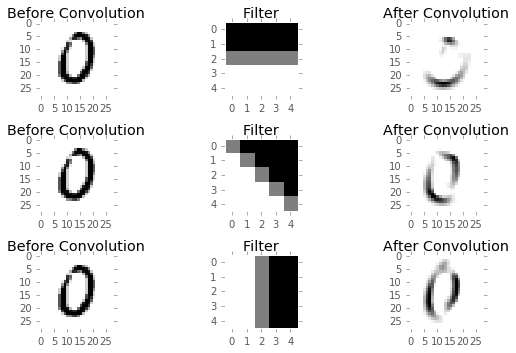

In [47]:
fig, axs = plt.subplots(3, 3, figsize=(8, 5))

clean_zero_h_edges = apply_relu(apply_convolution_to_image(clean_zero, horisontal_edge_filter))
plot_convolution(clean_zero, horisontal_edge_filter, clean_zero_h_edges, axs[0, :])

diagonal_edge_filter = np.array([
    [ 0,   1,    1,  1,   1],
    [-1,   0,    1,  1,   1],
    [-1,  -1,    0,  1,   1],
    [-1,  -1,   -1,  0,   1],
    [-1,  -1,   -1, -1,   0]
]).astype(np.float32)

clean_zero_d_edges = apply_relu(apply_convolution_to_image(clean_zero, diagonal_edge_filter))
plot_convolution(clean_zero, diagonal_edge_filter, clean_zero_d_edges, axs[1, :])

clean_zero_v_edges = apply_relu(apply_convolution_to_image(clean_zero, vertical_edge_filter))
plot_convolution(clean_zero, vertical_edge_filter, clean_zero_v_edges, axs[2, :])

remove_grid_lines(axs)
plt.tight_layout()

If we imagine that these edge detectors are the first convolutional layer of our CNN, then the output of this layer is a 3-tensor with the max-pooled outputs of the edge detectors stacked together.

--> Image of 3 convolution layer applied to zero.

In [48]:
stacked_filtered_zeros = np.stack([
    apply_max_pool_to_image(clean_zero_h_edges),
    apply_max_pool_to_image(clean_zero_d_edges),
    apply_max_pool_to_image(clean_zero_v_edges) 
], axis=-1)

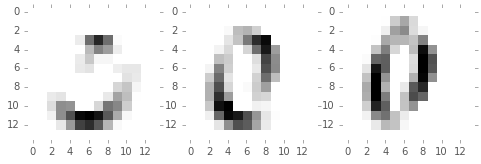

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
axs[0].imshow(stacked_filtered_zeros[:, :, 0], cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow(stacked_filtered_zeros[:, :, 1], cmap=plt.cm.gray_r, interpolation="nearest")
axs[2].imshow(stacked_filtered_zeros[:, :, 2], cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

To detect the curve of the upper left hand side of the zero, we will construct a convolution in our second layer that "glues together" the edge detectors.

More precisely, we will attempt to detect the *pattern of activations* from the convolutions in the first layer:
  - The activation from the horizontal edge detector at the top.
  - The activation from the diagonal detector slightly below and to the right of that.
  - The activation from the vertical detector slightly below and to the right of that.

In [50]:
# This is a simple template for a blob detector.
template = np.array([
    [0.25, 0.5, 0.25],
    [0.5,  1.0, 0.5],
    [0.25, 0.5, 0.25],
])

# Put together three blob detectors in the correct pattern.
three_filter = np.zeros((5, 5, 3), dtype=np.float32)

three_filter[:3, :3, 0] = template
three_filter[1:4, 1:4, 1] = template
three_filter[2:, 2:, 2] = template

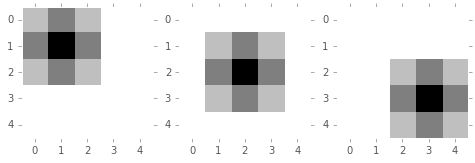

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
axs[0].imshow(three_filter[:, :, 0], cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow(three_filter[:, :, 1], cmap=plt.cm.gray_r, interpolation="nearest")
axs[2].imshow(three_filter[:, :, 2], cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

You can think of these filters as identifying where to "glue" the detectors from the first layer to create a pattern that will detect the curve we are after.

In [52]:
def apply_three_convolution_to_image_stack(images, filters):
    images_shape = images.shape
    image_tensor = tf.constant(
        images.reshape(1, images_shape[0], images_shape[1], images_shape[2]))
    filters_shape = filters.shape
    filter_tensor = tf.constant(
        filters.reshape(filters_shape[0], filters_shape[1], filters_shape[2], 1))
    convolved_tensor = tf.nn.conv2d(
        image_tensor, filter_tensor, 
        strides=[1, 1, 1, 1], padding='SAME')
    image_convloved = convolved_tensor.eval()[0, :, :, 0]
    return image_convloved

In [53]:
double_filtered_image = apply_three_convolution_to_image_stack(
    stacked_filtered_zeros, three_filter)

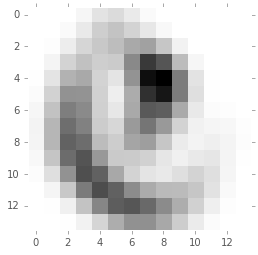

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(double_filtered_image, cmap=plt.cm.gray_r, interpolation="nearest")
ax.grid(False)

The strong activation in this picture (the mass of dense black pixels) serves to detect the feature we are after.

Essentially, if we lay down our three edge detectors from the first layer in the pattern defined by the second layer, centered on the point of strongest activation in the image above, we will detect the curve of the upper right hand side of the zero.

#### Tensorflow Code

Our network will contain 32 convolutional filters in the second layer.

This means we are creating 32 "patterns" for gluing the 16 convolutions from the **first** layer together so as to detect more complex features.

This means that overall, the second layer transforms the dimensions of the input tensor as:

```
(1, 14, 14, 16) -CONV-> (1, 14, 14, 32)
                -RELU-> (1, 14, 14, 32)
                -POOL-> (1, 7, 7, 32)
```

In [55]:
# 8 input channels, 16 convolutional filters.
weights2 = tf.Variable(
    tf.truncated_normal(shape=[5, 5, 16, 32], stddev=0.1))

bias2 = tf.Variable(tf.constant(0.1, shape=[32]))

conv2 = tf.nn.conv2d(layer_1_out, weights2,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

relu2 = tf.nn.relu(conv2 + bias2)

layer_2_out = tf.nn.max_pool(relu2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')    

### The Fully Connected Layer

To finish off the network, we add a fully connected layer, and then an output layer.

![Schematic of a Complete CNN End](./img/deep-network-end.png) 

The final fully connected layer will contain 128 final numeric features which are linear combinations of the higher level features from the second convolutional layer.

In [56]:
# There are 7*7*28 input values into this layer, and 128 output values.
weight_fully_connected_1 = tf.Variable(
    tf.truncated_normal(shape=[7 * 7 * 32, 128], stddev=0.1))

bias_fully_connected_1 = tf.Variable(tf.constant(0.1, shape=[128]))

# Flatten the output of the second layer.  This allows us to do
# a simple matrix multiplication with the weight matrix for the
# fully connected layer.
layer_2_out_flat = tf.reshape(layer_2_out, [-1, 7 * 7 * 32])
fully_connected_1_out = tf.nn.relu(
    tf.matmul(layer_2_out_flat, weight_fully_connected_1) + bias_fully_connected_1)

These 128 features are then connected to the output layer, which will give us our predictions for each digit.

In [57]:
weight_fully_connected_2 = tf.Variable(
    tf.truncated_normal(shape=[128, 10], stddev=0.1))

bias_fully_connected_2 = tf.Variable(tf.constant(0.1, shape=[10]))

# The output layer.
# Predictions, but on a log-odds scale.
fully_connected_2_out = tf.matmul(
    fully_connected_1_out, weight_fully_connected_2) + bias_fully_connected_2

### Training the Network

#### Loss Function and Regularization

To train our network, we need to set up a loss function.

As usual, we train our network by minimizing a cross entropy loss function.

We will add L2 regularization on all the weights in the network to prevent overfitting.  This is always a good idea, and much effort in training production CNNs is spent validating the choice of this (regularization strength) and other hyperparameters.

In [58]:
# The basic loss function, cross entropy.
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=fully_connected_2_out))

# Use L2 regularization on all the weights in the network.
regularization_strength = 0.01
regularization_term = regularization_strength * (
    tf.nn.l2_loss(weights1) +
    tf.nn.l2_loss(weights2) +
    tf.nn.l2_loss(weight_fully_connected_1) +
    tf.nn.l2_loss(weight_fully_connected_2)
)

# The total loss function we will minimize is cross entropy
# plus regularization.
total_loss = cross_entropy + regularization_term

#### Training The Network

The Tensorflow code to train the network is straightforward.

We will use a more sophisticated method than vanilla stochastic gradient descent, and use a very small learning rate.

In [59]:
# ADAM is a sophisticated version of gradient descent that adapts the
# learning rate over time.
train_step = tf.train.AdamOptimizer(0.00005).minimize(total_loss)

# Create a tensor to track the accuracy during training.
correct_prediction = tf.equal(tf.argmax(fully_connected_2_out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize everything and prepare for training.
sess.run(tf.global_variables_initializer())

Now let's run our training algorithm.  This takes a **long time** to train, on the order of half an hour.


We will keep track of training and testing error as we go.  Since the testing data takes some time to score, we will only do this every 1000 iterations of the descent.

In [60]:
# Run the gradient descent, printing out the training and
# testing accuracy every 1000 iterations.
train_accuracies, test_accuracies = [], []
training_epochs = 50000
for i in range(training_epochs):
    batch = mnist.train.next_batch(50)
    # Print out diagnostics every 1000 iterations
    if i % 1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y: batch[1]})

        print("step {}, training accuracy {:1.2f}".format(
            i, train_accuracy))
        # Save diagnostics for later.
        train_accuracies.append(train_accuracy)
    train_step.run(feed_dict={x: batch[0], y: batch[1]})

step 0, training accuracy 0.10
step 1000, training accuracy 0.88
step 2000, training accuracy 0.94
step 3000, training accuracy 0.94
step 4000, training accuracy 0.94
step 5000, training accuracy 0.96
step 6000, training accuracy 0.94
step 7000, training accuracy 0.96
step 8000, training accuracy 0.98
step 9000, training accuracy 0.98
step 10000, training accuracy 1.00
step 11000, training accuracy 1.00
step 12000, training accuracy 0.98
step 13000, training accuracy 0.96
step 14000, training accuracy 0.94
step 15000, training accuracy 0.98
step 16000, training accuracy 0.96
step 17000, training accuracy 1.00
step 18000, training accuracy 0.94
step 19000, training accuracy 0.98
step 20000, training accuracy 1.00
step 21000, training accuracy 0.96
step 22000, training accuracy 0.98
step 23000, training accuracy 1.00
step 24000, training accuracy 0.98
step 25000, training accuracy 0.98
step 26000, training accuracy 1.00
step 27000, training accuracy 0.98
step 28000, training accuracy 0.9

Our convolutional network has given us a nice increase in our ability to detect digits.

In [61]:
print("test accuracy %g" % accuracy.eval(feed_dict={
    x: mnist.test.images, y: mnist.test.labels}))

test accuracy 0.9823


#### Visualizing the First Layer

Now we can visualize the fit convolutions in the first layer of our network.

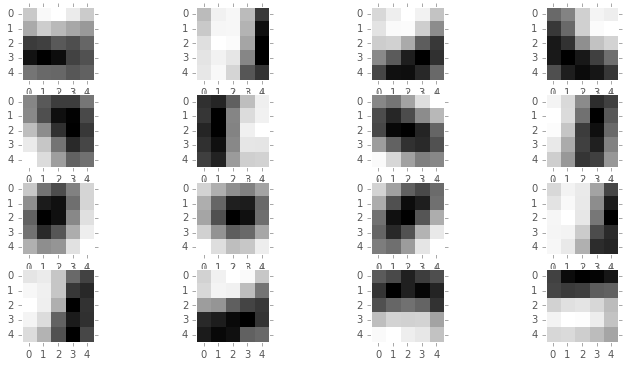

In [62]:
weights1_np = weights1.eval()

fig, axs = plt.subplots(4, 4, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    filter = weights1_np[:, :, 0, i]
    ax.imshow(filter, cmap=plt.cm.gray_r, interpolation="nearest")
    
remove_grid_lines(axs)

As stated earlier, the first layer convolutions show characteristic signs of being edge detectors.

Let's apply these filters to our digit from earlier:

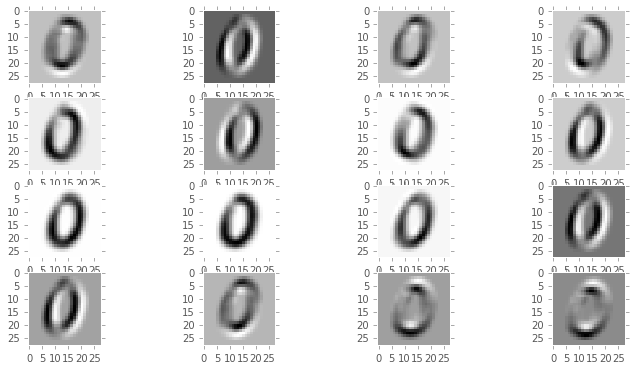

In [63]:
zero_tensor = tf.constant(clean_zero.reshape(1, 28, 28, 1))
zero_activations = tf.nn.conv2d(
    zero_tensor, weights1, strides=[1, 1, 1, 1], padding='SAME'
)
zero_activations_np = zero_activations.eval()

fig, axs = plt.subplots(4, 4, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(zero_activations_np[0, :, :, i], cmap=plt.cm.gray_r, interpolation="nearest")
    
remove_grid_lines(axs)

## Transfer Learning

One of the very nice things about convolutional networks is that their layered architecture means that they usually do not have to be trained from scratch.

Remember that the early convolutional layers in a network learn both low level and high level features.  Many of these features (edge detectors) should apply to **any** image recognition problem, so if we've learned them once, there's probably no need to learn them again.  This is the idea behind transfer learning.

###  A MNIST Variant

To demonstrate, we are going to to use our trained MNIST CNN to classify a different set of images.

To keep things simple, we will use a dataset derived from MNIST.  [This website](http://www.iro.umontreal.ca/~lisa/twiki/bin/view.cgi/Public/MnistVariations) has a few interesting derived datasets which add noise and new features to the basic MNIST data:

  - Random rotations of digits.
  - A random image added to teh background.
  - Random noise added to the background.
  
We are going to use the MNIST version with a random image in the background, but you should feel free to experiment with the others after class.

### Cleaning Raw Data

Unfortunately, the data you'll download from the website does not have a completely consistent format.  We've provided a script `clean_mnsit_data.sh` that will fix up the raw data into a consistent format.  To use the script:

```bash
./clean_mnsit_data.sh <your data set to be cleaned>.amat
```

The issues we identified with the data are:
  - An inconsistent number of spaces between the data elements (i.e. the numbers in the file).
  - Whitespace at the beginning of lines.
  
The cleanup script uses basic unix tools to clean off the beginning of line whitespace, and collapse the delimiting spaces into a single space.

```bash
# Collapse multiple consecutive spaces into a single space and then
# remove all spaces at the beginning of a line.
cat mnist_background_images_train.amat | sed "s/  */ /g" | sed "s/^ *//g" > mnist_background_images_train.amat.temp
cat mnist_background_images_test.amat | sed "s/  */ /g" | sed "s/^ *//g" > mnist_background_images_test.amat.temp
# Overwrite original files with temporary files.
mv mnist_background_images_train.amat.temp mnist_background_images_train.amat
mv mnist_background_images_test.amat.temp mnist_background_images_test.amat
```

### Loading Data into Tensorflow

Up until now, we have been using a dataset that is *already* loaded into Tensorflow, or data that already exists in numpy arrays.  This situation is a bit different, we have data on disk that we want to use.

The first thing we need to do is create a `reader` object that Tensorflow can stream the data from.  We do this in the function `create_mnist_reader` below.  It returns a `reader` object that can be used to stream data into Tensorflow in various ways.

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib
matplotlib.style.use('ggplot')

In [65]:
def create_mnist_reader(path):
    """Create and return a Tensorflow reader object for serving modified mnist data.
    
    Data is available for download at this url:
        http://www.iro.umontreal.ca/~lisa/twiki/bin/view.cgi/Public/MnistVariations
    Each file is a space separated file of floating point numbers with 785
    data elements on each line.
      - The first 784 elements represent a 28 by 28 image.
      - The last element is the class of the image.  It is an whole number between
        zero and nine (inclusive).  Note that it is still represented as a float,
        so 1.000000 (for example).
    """
    queue = tf.train.string_input_producer([path])
    reader = tf.TextLineReader()
    _, line = reader.read(queue)
    # Default values, in case of empty columns. Also specifies the type of the
    # decoded result.
    defualt_values = [[0.0]]*785
    csv_reader = tf.decode_csv(
        line, record_defaults=defualt_values, field_delim=" ")
    return csv_reader

Now we want to mimic the interface Tensorflow uses for the built in MNIST data, so that we can re-use some of our model code for the CNN we have already built.

Recall our code for training the CNN:

```python
training_epochs = 5000
for i in range(training_epochs):
    batch = mnist.train.next_batch(50)
    ...
```

The important point here is that the object representing our data has a `next_batch` method which returns *two numpy arrays*.

  - The first is a `(batch_size, image_height*image_width)` array containing a batch of training images.
  - The second is a `(batch_size, n_classes)` array containing one hot encoded labels for the training examples.

The class below consumes our reader object and creates an object with the `next_batch` object that we can plug into our code from before.

You can use it like:

```python
training_stream = MnistStream(training_reader)
...
# Get a batch of 50 images and labels
image_batch, label_batch = training_stream.next_batch(50)
```

In [66]:
class MnistStream(object):
    """Stream the manipulated MNIST datasets from disk using the same API
    as the built in mnist.train dataset.
    """
    
    def __init__(self, reader, batch_size=50, n_classes=10):
        self.n_classes = n_classes
        self.reader = reader
        self.batch_size = batch_size
        self.batch_generator = tf.train.batch([reader], batch_size=batch_size)
        
    def next_batch_total(self, sess):
        """Get the next batch of images and labels as a single tensor."""
        this_batch = sess.run([self.batch_generator])
        return this_batch[0]
    
    def next_batch(self, sess):
        """Get the next batch of images and labels as a pair of tensors.
        
          - The first tensor in the pair is a (batch_size, image_width*image_height)
            tensor containing images.
          - The second tensor in the pair is a (batch_size, n_classes) tensor
            containing one hot encoded labels for the images.
        """
        this_batch = self.next_batch_total(sess)
        # This reshaping is needed because the data from the website is stored in
        # column major order, while the tensorflow mnist data is stored in
        # row major order.
        train_batch = this_batch[:, :784].reshape(50, 28, 28).transpose([0, 2, 1]).reshape(50, -1)
        label_batch = this_batch[:, 784]
        one_hot_labels = np.zeros((self.batch_size, self.n_classes))
        one_hot_labels[np.arange(self.batch_size), label_batch.astype(np.int32)] = 1.0
        return train_batch, one_hot_labels

To try it all out, let's stream in some of the images from our downloaded MNIST dataset, and display the results along with their labels.

In [67]:
train_filename = "/Users/matthew.drury/Data/mnist/image-background/mnist_background_images_train.amat"
train_reader = create_mnist_reader(train_filename)

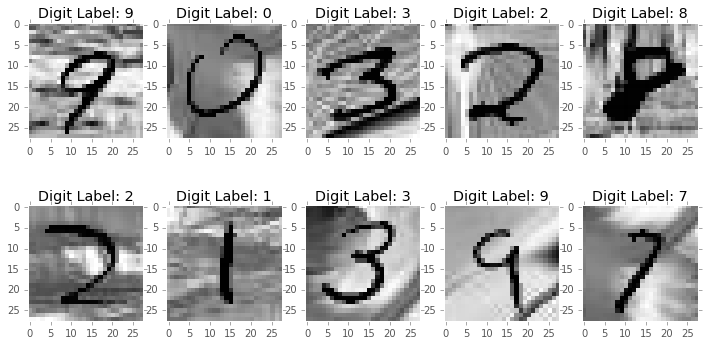

In [68]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# This line MUST come before starting the input queue in
# start_queue_runners.  Otherwise the process will hang
# indefinately.
mnist_stream = MnistStream(train_reader)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
# This prevents us from requesting data *before* the needed setup
# is complete.
while not coord.should_stop():
    fifty_images, fifty_labels = mnist_stream.next_batch(sess)
    fifty_images = fifty_images.reshape(50, 28, 28)
    for i, ax in enumerate(axs.flatten()):
        image = fifty_images[i, :, :]
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("Digit Label: {}".format(np.argmax(fifty_labels[i])))
    break

remove_grid_lines(axs)
coord.request_stop()
coord.join(threads)

### A Transfer Learning Class For Our MNIST Model

Now that we have our data streaming and ready to go, we can begin transfer learning.

Recall the architecture of our CNN for classifying MNIST digits:
    
![Schematic of a Complete CNN Beginning](./img/deep-network-begin.png)
![Schematic of a Complete CNN End](./img/deep-network-end.png) 

Our goal is to train this network on our new image data, but to **fix the values of the convolutional layers**.

This means that we are only going to retrain the weights for the fully connected layers at the end of the network.

To see why this makes sense, let's apply the convolutional weights we learned in our MNIST network to the new images.

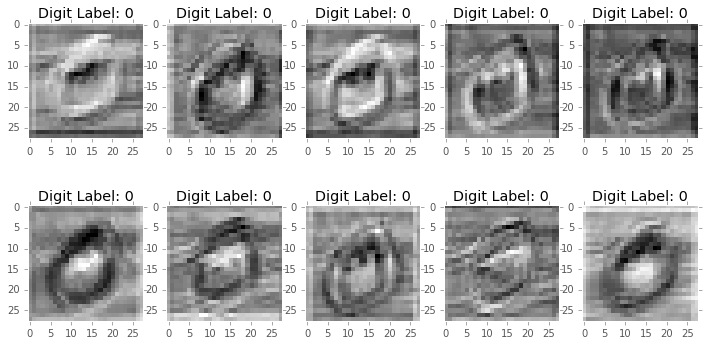

In [69]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

mnist_stream = MnistStream(train_reader, 50)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
# This prevents us from requesting data *before* the needed setup
# is complete.
while not coord.should_stop():
    fifty_images, fifty_labels = mnist_stream.next_batch(sess)
    fifty_images = fifty_images.reshape(50, 28, 28)
    for i, ax in enumerate(axs.flatten()):
        image = fifty_images[0, :, :].reshape(1, 28, 28, 1)
        image_convolved = apply_convolution_to_image(image, weights1.eval()[:, :, 0, i])
        ax.imshow(image_convolved, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("Digit Label: {}".format(np.argmax(fifty_labels[0])))
    break

remove_grid_lines(axs)
coord.request_stop()
coord.join(threads)

The edge detectors from our first layer still work and do their job.  There's really no need to retrain them on a batch of new images.

Given this it seems likely that we can have some success form leaving the convolutional weights in our network alone, and retraining only the weights in the fully connected layers that actually do the classification.

### Setting Up The Transfer Learning.

Conceptually, setting up the transfer learning is simple: we only need to make **constant** tensors out of the fit convolutional layers from our previous network:

```python
self.weights1_constant = tf.constant(weights1.eval())
self.bias1_constant = tf.constant(bias1.eval())
self.weights2_constant = tf.constant(weights2.eval())
self.bias2_constant = tf.constant(bias2.eval())
```

To facilitate doing this multiple times with different datasets, we've wrapped the code setting up a graph for our CNN in a class below. Initilizing this class will create an object that encapsulates all the tensors in our CNN:

```python
background_img_model = MnistModel()
```

Then we can train our transfer model by passing it a stream of new data.

```python
mnist_stream = MnistStream(train_reader)
...
background_img_model.fit(mnist_stream, 50)
```

In [70]:
class MnistTransferModel(object):
    """A model which, when trained, does transfer learning using the CNN we
    trained on the MNIST data set.
    
    This model fixes the weights learned when training our CNN on MNIST,
    but keeps the weights in the two hidden layers as varaible.  Training
    this model on new data only retraines the weights in the hidden layer
    on whatever batch of images we feed into it.
    """
    
    def __init__(self, n_hidden=128, n_classes=10):
        """Setup the tensorflow model for our transfer learning.
        
        This function defines the complete graph needed to train our 
        transfer model.  The structure is exactly the same as our MNIST 
        model, only with convolutional weights and biases fixed.
        """
        # Constant tensors to hold the weights that will be kept fixed in the
        # new model.
        self.weights1_constant = tf.constant(weights1.eval())
        self.bias1_constant = tf.constant(bias1.eval())
        self.weights2_constant = tf.constant(weights2.eval())
        self.bias2_constant = tf.constant(bias2.eval())
        
        # Tensors representing our input dataset and our input labels
        self.x = tf.placeholder(tf.float32, shape=[None, 28*28])
        self.y = tf.placeholder(tf.float32, shape=[None, n_classes])
        
        # When passing through the network, we want to represent the images
        # as a 4-tensor: (n_images, image_height, image_width, n_channels)
        self.x_image = tf.reshape(self.x, [-1, 28, 28, 1])
        
        # Varaibles to hold weights iand biasies n the hidden fully
        # connected layer.
        self.weight_fully_connected_1 = tf.Variable(
            tf.truncated_normal(shape=[7 * 7 * 32, n_hidden], stddev=0.1))
        self.bias_fully_connected_1 = tf.Variable(tf.constant(0.1, shape=[n_hidden]))
        
        # First Layer Definition
        self.conv1 = tf.nn.conv2d(self.x_image, self.weights1_constant,
                             strides=[1, 1, 1, 1],
                             padding='SAME')
        self.relu1 = tf.nn.relu(self.conv1 + self.bias1_constant)
        self.layer_1_out = tf.nn.max_pool(self.relu1,
                                          ksize=[1, 2, 2, 1],
                                          strides=[1, 2, 2, 1],
                                          padding='SAME')   

        # Second Layer Definition      
        self.conv2 = tf.nn.conv2d(self.layer_1_out, self.weights2_constant,
                                  strides=[1, 1, 1, 1],
                                  padding='SAME')
        self.relu2 = tf.nn.relu(self.conv2 + self.bias2_constant)
        self.layer_2_out = tf.nn.max_pool(self.relu2,
                                          ksize=[1, 2, 2, 1],
                                          strides=[1, 2, 2, 1],
                                          padding='SAME')
        # Fully Connected Hidden Layer
        self.weight_fully_connected_1 = tf.Variable(
            tf.truncated_normal(shape=[7 * 7 * 32, n_hidden], stddev=0.1))
        self.bias_fully_connected_1 = tf.Variable(tf.constant(0.1, shape=[n_hidden]))
        self.layer_2_out_flat = tf.reshape(self.layer_2_out, [-1, 7 * 7 * 32])
        self.fully_connected_1_out = tf.nn.relu(
            tf.matmul(
                self.layer_2_out_flat, self.weight_fully_connected_1) + 
                self.bias_fully_connected_1)
        
        # Fully Connected Output Layer
        self.weight_fully_connected_2 = tf.Variable(
            tf.truncated_normal(shape=[n_hidden, n_classes], stddev=0.1))
        self.bias_fully_connected_2 = tf.Variable(tf.constant(0.1, shape=[n_classes]))
        self.fully_connected_2_out = (tf.matmul(
            self.fully_connected_1_out, self.weight_fully_connected_2) + 
                self.bias_fully_connected_2)
        
        # Loss Function Definition
        self.cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=self.y, 
                                                    logits=self.fully_connected_2_out))
        regularization_strength = 0.01
        self.regularization_term = regularization_strength * (
            tf.nn.l2_loss(self.weight_fully_connected_1) +
            tf.nn.l2_loss(self.weight_fully_connected_2)
        )
        self.total_loss = self.cross_entropy + self.regularization_term
        
        # Model Evaluation Metrics
        self.correct_prediction = tf.equal(tf.argmax(self.fully_connected_2_out, 1), 
                                           tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
    def fit(self, sess, input_queue, n_epochs=5000, learning_rate=0.00005, verbose=True):
        """Fit the transfer model to a new batch of 28 by 28 images."""
        # Setup the optimizer.
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.total_loss)
        sess.run(tf.global_variables_initializer())
        # Train the model.
        self.train_accuracies = []
        for i in range(n_epochs):
            batch = input_queue.next_batch(sess)
            # Print out diagnostics every 1000 iterations.
            if i % 1000 == 0 and verbose:
                train_accuracy = self.accuracy.eval(feed_dict={
                    self.x: batch[0], self.y: batch[1]})
                print("step {}, training accuracy {:1.2f}".format(i, train_accuracy))
                train_accuracies.append(train_accuracy)
            train_step.run(feed_dict={self.x: batch[0], self.y: batch[1]})

Now let's train on our new dataset.

In [71]:
image_mnist_model = MnistTransferModel()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# This line MUST come before starting the input queue in
# start_queue_runners.  Otherwise the process will hang
# indefinately.
mnist_stream = MnistStream(train_reader, 50)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

image_mnist_model.fit(sess, mnist_stream, n_epochs=25000)

coord.request_stop()
coord.join(threads)

step 0, training accuracy 0.06
step 1000, training accuracy 0.36
step 2000, training accuracy 0.62
step 3000, training accuracy 0.70
step 4000, training accuracy 0.76
step 5000, training accuracy 0.68
step 6000, training accuracy 0.62
step 7000, training accuracy 0.72
step 8000, training accuracy 0.68
step 9000, training accuracy 0.78
step 10000, training accuracy 0.84
step 11000, training accuracy 0.70
step 12000, training accuracy 0.68
step 13000, training accuracy 0.72
step 14000, training accuracy 0.72
step 15000, training accuracy 0.78
step 16000, training accuracy 0.84
step 17000, training accuracy 0.74
step 18000, training accuracy 0.68
step 19000, training accuracy 0.74
step 20000, training accuracy 0.72
step 21000, training accuracy 0.78
step 22000, training accuracy 0.84
step 23000, training accuracy 0.74
step 24000, training accuracy 0.68


And see how we did on hold out data.

In [ ]:
test_filename = "/Users/matthew.drury/Data/mnist/image-background/mnist_background_images_test.amat"
test_reader = create_mnist_reader(test_filename)

In [ ]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# This line MUST come before starting the input queue in
# start_queue_runners.  Otherwise the process will hang
# indefinately.
mnist_stream = MnistStream(test_reader, 5000)
image_array, label_array = mnist_stream.next_batch(sess)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

image_mnist_model.accuracy.eval(feed_dict={
    image_mnist_model.x: image_array,
    image_mnist_model.y: label_array})

coord.request_stop()
coord.join(threads)

In your afternoon assignment, you'll be using the network you trained this morning to transfer learn a new dataset.